# Arrhythmia Classifier

## The Problem
- Cardiovascular diseases cause around 17.9 million deaths annually, mainly due to heart attacks and strokes which are preceded by arrhythmias [1,2]
- While Electrocardiograms (ECGs) are crucial for diagnosing arrhythmias, they typically capture only short periods of cardiac activity. This limitation means potentially dangerous arrhythmias might not occur during the test, making detection challenging. Moreover, formal testing can be inconvenient and requires significant resources [2,3]
- Implantable loop recorders (ILR) offer continuous ECG monitoring but rely on manual symptom reporting by patients, which can be unreliable if patients do not consistently report symptoms or fail to recognize them [4]
- There is significant potential for technology that enables automatic and continuous monitoring of ECGs. Such advancements could substantially improve outcomes by providing early warnings for arrhythmias that may lead to heart attacks or strokes, thereby improving timely medical intervention


### Thus, we have built an arrhythmia classifier using the Machine Learning pipeline

## Dataset Collection
- We found the dataset "A large scale 12-lead electrocardiogram database for arrhythmia study" on the site "PhysioNet"
- The dataset contains 45,152 samples
- Each sample has 12 leads of electrocardiogram (ECG) data as the input, and a list of conditions (e.g. afibrillation \[arrhythmia\], sinus rhythm \[non-arrhythmia\]) as the output
- ECG data was collected for 10 seconds at a sampling rate of 500 Hz

To access the dataset, do the following:
1. Create a kaggle account.
2. Go to "settings" and generate an API key.
3. In your Google colab tab, click on the key icon on the left sidebar, and input two secrets as follows:
```
username: [your kaggle username]
key: [your api key]
```
4. Uncomment and run the following script.

In [ ]:
from google.colab import userdata
import json

kaggle_dict = { 'username': userdata.get('kaggleUsername'), 'key': userdata.get('kaggleKey') }

with open('kaggle.json', 'w') as f:
  json.dump(kaggle_dict, f)

! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download deepankarvarma/chapman-ecg-database
! unzip -o chapman-ecg-database.zip | tail -n 10



100% 2.32G/2.33G [00:34<00:00, 112MB/s] 
100% 2.33G/2.33G [00:34<00:00, 71.8MB/s]
  inflating: a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/46/461/JS45547.mat  
  inflating: a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/46/461/JS45548.hea  
  inflating: a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/46/461/JS45548.mat  
  inflating: a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/46/461/JS45549.hea  
  inflating: a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/46/461/JS45549.mat  
  inflating: a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/46/461/JS45550.hea  
  inflating: a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/46/461/JS45550.mat  
  inflating: a-large-scale-12-lead-electrocardiogram-database-fo

5. Install necessary python libraries

In [ ]:
!pip install scipy
!pip install numpy
!pip install pandas

You should now have a folder called "a-large-scale-12-lead-electrocardi...". It has a subfolder "WFDBRecords" containing 45,152 files (stored in chunks of 100) representing the 45,152 patients providing 10 seconds of 500Hz sampled 12-lead ECG data.

6. Run the following script to store the inputs and targets in numpy arrays

Note: Because the inputs are so large, we use a memory-mapped array to make use of disk storage

In [ ]:
from scipy.io import loadmat
import numpy as np

import os
import re

x_shape = (45152, 12, 5000)
dtype = 'int16'
x_ecg = np.memmap('x_ecg.npy', dtype=dtype, mode='w+', shape=x_shape)
y_ecg = []

index = 0
directory = 'a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/'
with open(f'{directory}RECORDS', 'r') as file:
    records = []
    for record in file:
        record = record.strip()
        records.append(record)
for record in records:
    with open(f'{directory}{record}RECORDS') as f:
        bin_records = []
        for bin_record in f:
            bin_record = bin_record.strip()
            bin_records.append(bin_record)
    for bin_record in bin_records:
        x_path = f'{directory}{record}{bin_record}.mat'
        y_path = f'{directory}{record}{bin_record}.hea'
        mat_file = loadmat(x_path)
        x_i = np.array(mat_file['val'])
        with open(y_path) as y_f:
            lines = [line.rstrip() for line in y_f]
            y_i = np.array(lines[15].split(" ")[1].split(","))
            y_ecg.append(y_i)
        x_ecg[index] = x_i
        index+=1

7. To map the target SMOMED CT values (SNOMED Clinical Terms, system for denoting medical conditions as numerical IDs) with their written names, import the spreadsheet from the dataset

In [ ]:
import pandas as pd

df = pd.read_csv(f'{directory}ConditionNames_SNOMED-CT.csv')
print(df.count())
df.head(63)

Acronym Name    63
Full Name       63
Snomed_CT       63
dtype: int64


,Acronym Name,Full Name,Snomed_CT
0,1AVB,1 degree atrioventricular block,270492004
1,2AVB,2 degree atrioventricular block,195042002
2,2AVB1,2 degree atrioventricular block(Type one),54016002
3,2AVB2,2 degree atrioventricular block(Type two),28189009
4,3AVB,3 degree atrioventricular block,27885002
...,...,...,...
58,SVT,Supraventricular Tachycardia,426761007
59,AT,Atrial Tachycardia,713422000
60,AVNRT,Atrioventricular Node Reentrant Tachycardia,233896004
61,AVRT,Atrioventricular Reentrant Tachycardia,233897008


You are ready to use the dataset!

Here is an example of accessing one ECGlead from an entry in the input, its corresponding target(s), and the written out form of those outputs

In [ ]:
x_9 = x_ecg[:,9,:]
entry_x = x_9[0]
entry_y = y_ecg[0]

print("Entry:")
print(entry_x)
print("Input shape", np.shape(entry_x))
print(entry_y)
print("Output shape", np.shape(entry_y))
for condition in entry_y:
  entry_df = df.loc[df['Snomed_CT'] == int(condition)]
  print(entry_df['Full Name'].to_string())

Entry:
[ 810  810  810 ... -205 -200 -171]
Input shape (5000,)
['164889003' '59118001' '164934002']
Output shape (3,)
54    Atrial Fibrillation
35    right bundle branch block
41    T wave Change


## Data Exploration
- To visualize samples of the dataset from each class, examples of non-arrhythmia vs. arrhythmia  (in this case, atrial fibrillation) were plotted on time-series charts

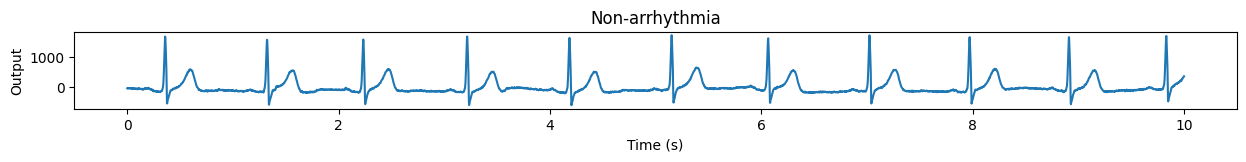

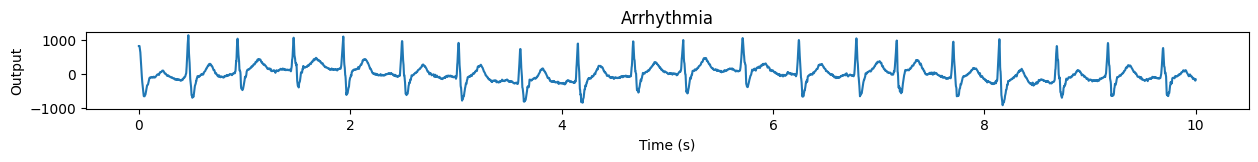

In [ ]:
normal_ecg_indices = []
afib_indices = []

num_samples = 1
for i, labels in enumerate(y_ecg):
  if len(labels) == 1 and labels[0] == '426783006' and len(normal_ecg_indices) < num_samples:
    normal_ecg_indices.append(i)
  if "164889003" in labels and len(afib_indices) < num_samples:
    afib_indices.append(i)

%matplotlib inline
import matplotlib.pyplot as plt
graph_x = np.linspace(0,10,5000)

for i in normal_ecg_indices:
  plt.figure(figsize=(15,1))
  plt.plot(graph_x, x_9[i])
  plt.title("Non-arrhythmia")
  plt.xlabel("Time (s)")
  plt.ylabel("Output")

for i in afib_indices:
  plt.figure(figsize=(15,1))
  plt.plot(graph_x, x_9[i])
  plt.title("Arrhythmia")
  plt.xlabel("Time (s)")
  plt.ylabel("Output")

- As well, the overall data distribution of arrhythmia vs. non arrhythmia was determined

In [ ]:
binary_labels = [1 if '426783006' not in y else 0 for y in y_ecg]
arrhythmia_count = 0
for i in binary_labels:
  if i: arrhythmia_count += 1
print('Class 0 (Non-arrhythmia):', len(binary_labels) - arrhythmia_count)
print('Class 1 (Arrhythmia):', arrhythmia_count)

Class 0 (Non-arrhythmia): 8125
Class 1 (Arrhythmia): 37027


## Pre-processing
- As seen above, we converted the dataset’s targets from lists of conditions to a binary 1 for arrhythmia and 0 for non-arrhythmia by filtering the targets based on if they had the provided label indicating normal heart beat or not to accomplish our task of classifying arrhythmias
- We chose to extract the lead at index 9 and discard the other leads because it had the clearest PQRST waves during data exploration, thus giving the clearest relationships to capture in a learning model, and because this is an approach used in research [5]
- For logistic regression, we extracted the R-R intervals, or lengths of gaps between “R” peaks in ECG signals to use as inputs to the learner to significantly reduce training time for this simpler model

In [ ]:
# prepare the data for CNN
X = x_ecg[:,9,:].reshape(-1, 5000, 1)  # focusing on lead 9
Y = np.array(binary_labels)

## Data Analysis with Machine Learning

###CNN
In our project, we classify ECG patterns as normal or arrhythmic using a Convolutional Neural Network (CNN), a method that is especially well-suited for handling time-series data, such as ECG signals. Our CNN architecture enhances pattern detection linked to heart rhythms by extracting and downsampling features from the ECG data using a combination of convolutional layers and max pooling layers. This process advances to dense layers, which results in a sigmoid output for binary classification. A dropout layer is included to prevent overfitting.

Because of their effectiveness in managing noisy gradients and applicability to binary classification problems, we selected the binary cross-entropy loss and the Adam optimizer. In order to ensure strong performance on untested data, the model is continuously validated after being trained on a split dataset. This approach is essential for real-world applications because precise and timely identification of arrhythmias can have a substantial influence on patient outcomes as well as optimizing learning.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4991, 16)          176       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1247, 16)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1238, 32)          5152      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 309, 32)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 9888)              0         
                                                                 
 dense (Dense)               (None, 64)                6

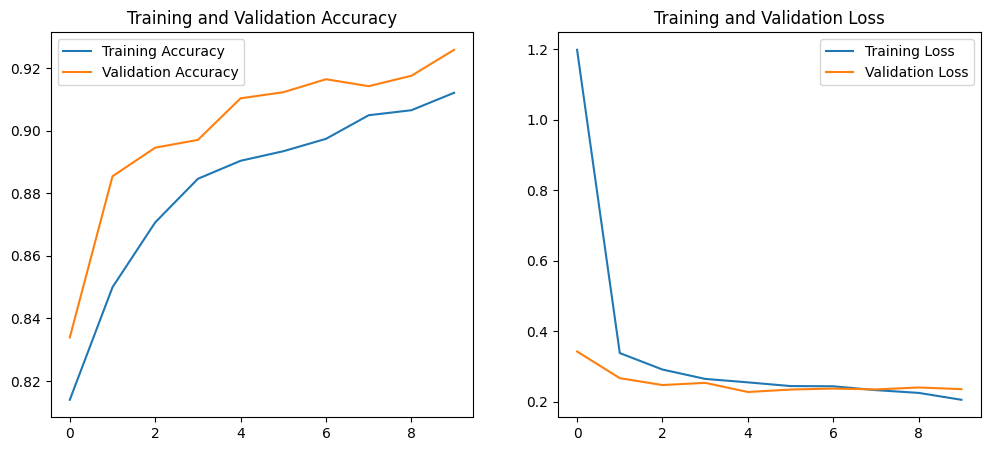

In [ ]:
from scipy.io import loadmat
import numpy as np
import os
import re
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# prepare the data for CNN
X = x_ecg[:,9,:].reshape(-1, 5000, 1)  # focusing on lead 9
Y = np.array(binary_labels)

# splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# build the CNN model
model = Sequential([
    Conv1D(filters=16, kernel_size=10, activation='relu', input_shape=(5000, 1)), # convolutional layer with 16 filters
    MaxPooling1D(pool_size=4), # pooling layer to reduce dimensions
    Conv1D(filters=32, kernel_size=10, activation='relu'), # another convolutional layer with 32 filters
    MaxPooling1D(pool_size=4), # another pooling layer to reduce dimensions
    Flatten(), # flatten output for dense layers
    Dense(64, activation='relu'), # dense layer with 64 units
    Dropout(0.5), # dropout for regularization
    Dense(1, activation='sigmoid') # output layer with sigmoid for binary classification
])

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# training the model on the training data with 10% used for validation
history = model.fit(X_train, Y_train, epochs=10, validation_split=0.1, batch_size=32)

# evaluating the trained model on the test data to get the final accuracy
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

# plotting the training and validation accuracy and loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Evaluation Metrics for CNN

With an initial AUC of 0.95 suggesting good sensitivity, especially for detecting arrhythmias, the CNN model demonstrates that it classifies ECG signals well and separates the classes well as demonstrated by the performance metrics. Concerns about initial specificity were indicated by a low true negative rate and a less than ideal f1-score for non-arrhythmias. Following adjusting the threshold, specificity increased dramatically while maintaining sensitivity, as shown by a balanced rise in the f1-scores and a sustained AUC of 0.95. This improvement highlights the model's efficacy as an ECG classification tool and highlights the significance of threshold tuning in model optimization for clinical settings.

283/283 [==============================] - 7s 25ms/step


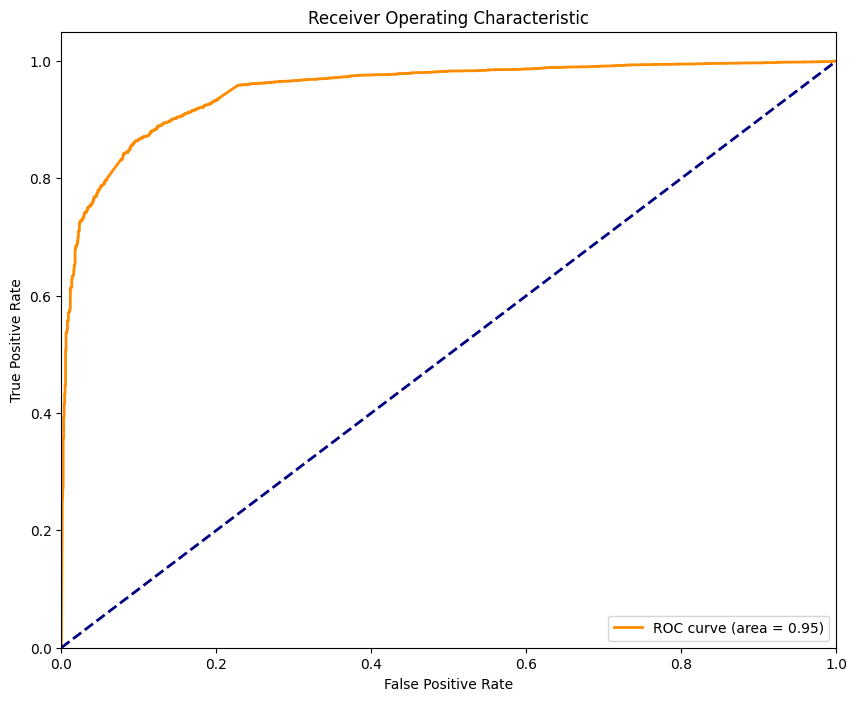

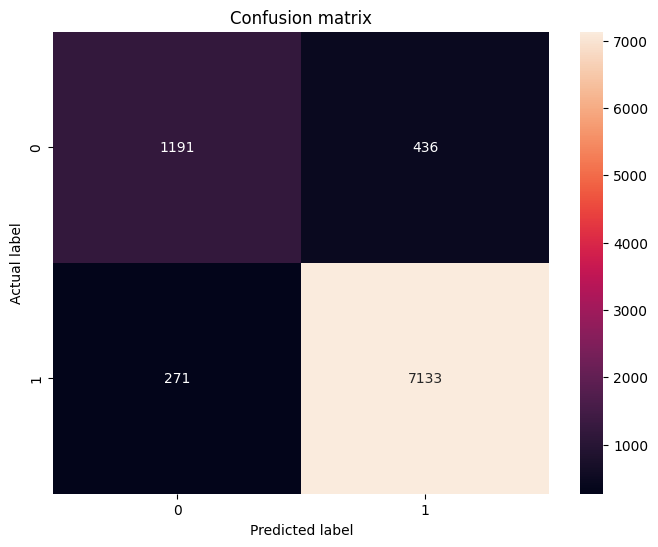

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1627
           1       0.94      0.96      0.95      7404

    accuracy                           0.92      9031
   macro avg       0.88      0.85      0.86      9031
weighted avg       0.92      0.92      0.92      9031

283/283 [==============================] - 7s 26ms/step
[[1250  377]
 [ 301 7103]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1627
           1       0.95      0.96      0.95      7404

    accuracy                           0.92      9031
   macro avg       0.88      0.86      0.87      9031
weighted avg       0.92      0.92      0.92      9031



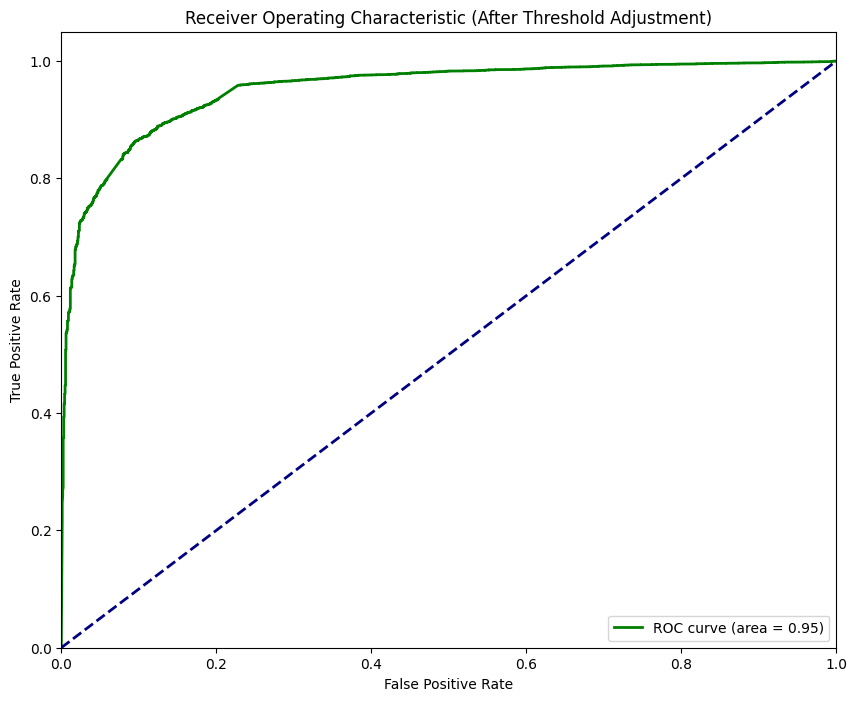

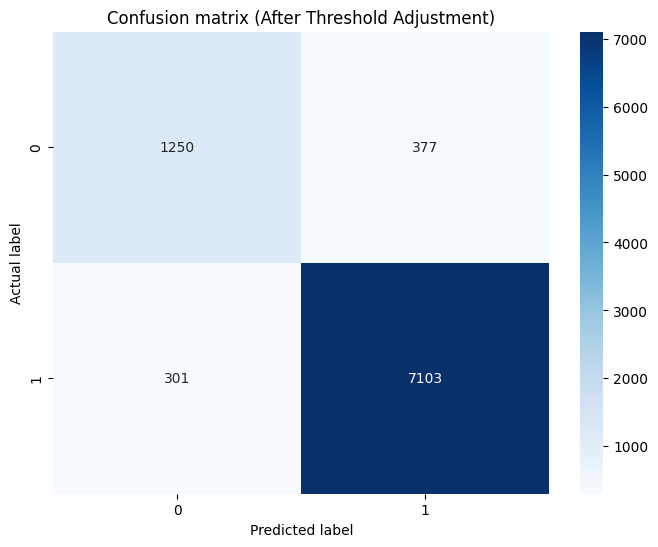

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns
import json
from sklearn.metrics import precision_recall_curve

# predict probabilities for test set
Y_pred = model.predict(X_test).ravel() # flattens array

# calculates roc curve data
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr) # calculates auc

# plots roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# convert probabilities to binary classification
Y_pred_binary = (Y_pred > 0.5).astype(int)

# calculate and visualize the confusion matrix
cm = confusion_matrix(Y_test, Y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(Y_test, Y_pred_binary))

# store performance metrics
performance_metrics = {
    'fpr': fpr.tolist(),
    'tpr': tpr.tolist(),
    'auc': roc_auc,
    'confusion_matrix': cm.tolist(),
    'classification_report': classification_report(Y_test, Y_pred_binary, output_dict=True)
}

# save performance metrics in a json file
with open('performance_metrics.json', 'w') as f:
    json.dump(performance_metrics, f)

Y_pred_probs = model.predict(X_test)[:, 0]

# calculate precision and recall for different thresholds
precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_pred_probs)

# calculate f1 scores for the precision-recall pairs
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# find the best threshold based on the highest f1 score
best_threshold = thresholds[np.argmax(f1_scores)]

# apply the best threshold to convert probabilities to binary classification
Y_pred_custom_threshold = (Y_pred_probs > best_threshold).astype(int)

# calculate and print the new confusion matrix after threshold adjustment
new_confusion_matrix = confusion_matrix(Y_test, Y_pred_custom_threshold)
new_classification_report = classification_report(Y_test, Y_pred_custom_threshold)
print(new_confusion_matrix)

# print the new classification report after threshold adjustment
print(new_classification_report)

# calculate the new roc curve data after threshold adjustment
fpr_new, tpr_new, thresholds_new = roc_curve(Y_test, Y_pred_probs)

# calculate the new area under the roc curve after threshold adjustment
roc_auc_new = auc(fpr_new, tpr_new)

# plot the new roc curve after threshold adjustment
plt.figure(figsize=(10, 8))
plt.plot(fpr_new, tpr_new, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_new)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (After Threshold Adjustment)')
plt.legend(loc="lower right")
plt.show()

# visualize the new confusion matrix after threshold adjustment
plt.figure(figsize=(8, 6))
sns.heatmap(new_confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix (After Threshold Adjustment)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#Random Forest

CNN is the most computationally expensive model thus far, so it would be best to use a model with comporable results that uses less computing power. Since we are focusing on binary classification from a single input, multiple decision trees could not only streamline classification accuracy but it could reduce the risk of overfitting. This is important since our dataset is inherently skewed in favor of the majority class 1 data.

Before adjusting the thresholds and balancing the model, the dataset was once again favoring class 1. After adjustments, the performance outcomes are more balanced between the two classes but CNN still has the preferrable performance.  

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# create and train a random forest with 100 decision trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), Y_train)

# predict the class labels and probabilities on the test data
Y_pred_rf = rf_model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_rf_probs = rf_model.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1]

# calculate model accuracy and generate a classification report for review
rf_accuracy = accuracy_score(Y_test, Y_pred_rf)
rf_classification_report = classification_report(Y_test, Y_pred_rf)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(rf_classification_report)

# adjusting thresholds and balancing the random forest model to improve performance
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf_model.fit(X_train.reshape(X_train.shape[0], -1), Y_train)
Y_pred_brf = brf_model.predict(X_test.reshape(X_test.shape[0], -1))
print("Balanced Random Forest:")
print(classification_report(Y_test, Y_pred_brf))

Y_pred_prob_brf = brf_model.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1]

# adjusting the predicted class labels based on the new threshold
new_threshold = 0.45

Y_pred_brf_adjusted = (Y_pred_prob_brf >= new_threshold).astype(int)

print("Balanced Random Forest with Adjusted Threshold:")
print(classification_report(Y_test, Y_pred_brf_adjusted))

Random Forest Accuracy: 0.8415457867345809
              precision    recall  f1-score   support

           0       0.86      0.15      0.25      1627
           1       0.84      0.99      0.91      7404

    accuracy                           0.84      9031
   macro avg       0.85      0.57      0.58      9031
weighted avg       0.84      0.84      0.79      9031



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

Balanced Random Forest:
              precision    recall  f1-score   support

           0       0.46      0.82      0.59      1627
           1       0.95      0.79      0.86      7404

    accuracy                           0.79      9031
   macro avg       0.71      0.81      0.73      9031
weighted avg       0.86      0.79      0.81      9031

Balanced Random Forest with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.61      0.68      0.64      1627
           1       0.93      0.90      0.92      7404

    accuracy                           0.86      9031
   macro avg       0.77      0.79      0.78      9031
weighted avg       0.87      0.86      0.87      9031



#Logistic Regression

With previous and more computing-intensive models already implemented, this linear classification model establishes a clear baseline for what ECG signals the ML model can recognize. Especially since there were earlier issues with the CNN model before, where the minority class (class 0) of non-arrythmia signals suffers from a trade-off, this model can help determine if there is slight overfitting due to the nature of the data or if it's how the previous models were built.

In this case, logistic regression is best since it’s not as computationally expensive and can make good predictions related to binary classification. To reiterate, our inputs are the R intervals from the selected lead 9 ECG signals while the output is the binary classification between class 0 -- the majority of ECG signals highlighting arrthymia and heartbeat irregularities -- versus class 1 -- the minority of ECG signals with little to no heartbeat irregularities. The input was pre-processed to become re intervals

In this first run, the precision, recall, and F1-score are all lower than average for class 0 but class 1 is able to pass with a somewhat satisying accuracy. This indicates that there is a bias towards class 1, most likely due to the size imbalance within the dataset; threshold modification is needed.

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# extracting the specific r intervals from the ecg signals
def extract_rr_intervals(ecg_signals):
    rr_intervals = []
    for signal in ecg_signals:
        peaks, _ = find_peaks(signal, height=np.mean(signal))
        rr_interval = np.diff(peaks)
        rr_intervals.append(np.mean(rr_interval))
    return np.array(rr_intervals).reshape(-1, 1)

# passing the data into a 2d array so it's not as computationally draining
x_ecg_flat = x_ecg.reshape(x_ecg.shape[0], -1)
rr_intervals = extract_rr_intervals(x_ecg_flat)

# creating labels for dataset and splitting into training and testing sets
labels = np.array([1 if '426783006' not in y else 0 for y in y_ecg])

X_train, X_test, Y_train, Y_test = train_test_split(rr_intervals, labels, test_size=0.2, random_state=42)

# standardize the features by removing the mean and scaling to the unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# running the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')
logistic_model.fit(X_train_scaled, Y_train)

Y_pred = logistic_model.predict(X_test_scaled)

report = classification_report(Y_test, Y_pred)
print(report)


Here the model is balanced and the thresholds are adjusted. In spite of these modifications, the model didn't identify anything meaningful in the minority class 0 and still favored class 1, thus highlighting a skewed dataset in favor of the majority class 1.

Because the previous ML models were still able to perform with satisfactory results, this indicates there isn't a linear connection between just the R intervals and the type of signal we're attempting to identify (arrythmia or non-arrythmia). CNN and Random Forest are able to identify more complex, non-linear relationships, resulting in a higher accuracy.

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#similar r interval extraction, data splitting, and training/testing for logistic regression
def extract_rr_intervals(ecg_signals):
    rr_intervals = []
    for signal in ecg_signals:
        peaks, _ = find_peaks(signal, height=np.mean(signal))
        rr_interval = np.diff(peaks)
        rr_intervals.append(np.mean(rr_interval))
    return np.array(rr_intervals).reshape(-1, 1)

x_ecg_flat = x_ecg.reshape(x_ecg.shape[0], -1)
rr_intervals = extract_rr_intervals(x_ecg_flat)

labels = np.array([1 if '426783006' not in y else 0 for y in y_ecg])

X_train, X_test, Y_train, Y_test = train_test_split(rr_intervals, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# training the logistic regression model on the scaled training data and predicting test probabilities
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')
logistic_model.fit(X_train_scaled, Y_train)

Y_pred_probs = logistic_model.predict_proba(X_test_scaled)[:, 1]

# generating thresholds for tuning
thresholds = np.arange(0.01, 1, 0.01)
f1_scores = [f1_score(Y_test, Y_pred_probs > t, zero_division=1) for t in thresholds]

# finding the index of the optimal threshold based on maximum F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold by F1 Score: {optimal_threshold}")

Y_pred_optimal = (Y_pred_probs >= optimal_threshold).astype(int)

optimal_report = classification_report(Y_test, Y_pred_optimal)
print("Classification report with optimal threshold by F1 Score:")
print(optimal_report)


#Conclusions

Overall, the CNN model performed best based on the precision, recall, and F1-scores. Although it's the most computationally expensive out of the 3 models analyzed, it has the most balanced peformance between class 0 and class 1. Because there is not a direct, linear relationship between the R interval inputs and the classification outputs, it's important that the optimal model can account for this nonlinear relationship. CNN is preferred over Random Forest, in this aspect, simply due to the model's higher accuracy when analyzing the data.

Although the accuracy for the Logistic Regression model is quite high, it is misleading because the model has significantly more instances of class 1 than class 0, so it prioritizes accuracy for class 1 in effect. This could also suggest that R intervals are not enough to distinguish between classes, and this is especially not captured in a linear model. As a result, CNN and Random Forests perform much better overall because they capture more complex relationships.